# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Data Preprocessing

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
saniya_palette = [
    "#fba1c2", "#152f64", "#886893", "#fff3f8", "#e58ab5",
    "#5c4b85", "#30477f", "#d88fad", "#cab0d5", "#9e7fb3",
    "#3f5d96", "#ffcadb", "#6f5a92", "#a3c3eb", "#b87aa7"
]

sns.set_palette(saniya_palette) #for setting the default palette

In [4]:
df = pd.read_csv("customer.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [8]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [9]:
mapping = { #map the values to new values
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [10]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [11]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [13]:
df['route'].value_counts()

route
AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
LBUTPE       1
CXRMEL       1
DELKBR       1
KOSSYD       1
MRUXIY       1
Name: count, Length: 799, dtype: int64

### EDA

C:\Users\saniy\AppData\Local\Temp\ipykernel_40516\1253087338.py:5: UserWarning: The palette list has more values (15) than needed (7), which may not be intended.
  sns.countplot(x='flight_day',data=df, ax=ax[1,0],hue='flight_day',palette=saniya_palette)


<Axes: xlabel='flight_duration', ylabel='Count'>

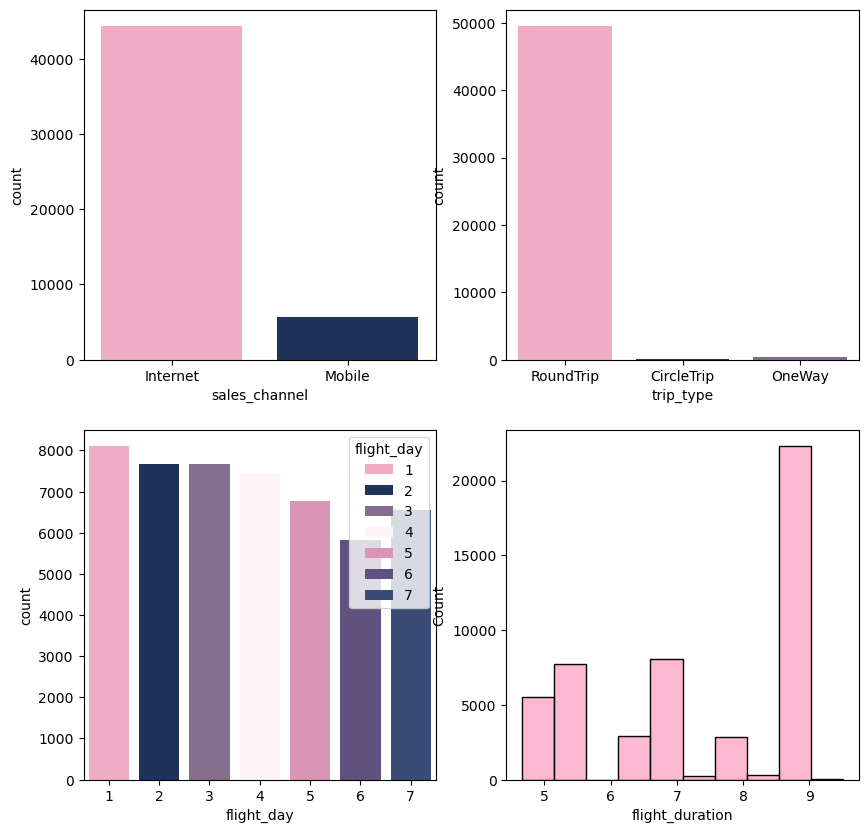

In [15]:
#univariate analysis
fig, ax=plt.subplots(2,2, figsize=(10,10))
sns.countplot(x='sales_channel',data=df, ax=ax[0,0],hue='sales_channel')
sns.countplot(x='trip_type',data=df, ax=ax[0,1],hue='trip_type')
sns.countplot(x='flight_day',data=df, ax=ax[1,0],hue='flight_day',palette=saniya_palette)
sns.histplot(x='flight_duration',data=df, ax=ax[1,1],bins=10)
#sns.countplot(x='booking_origin',data=df, ax=ax[1,1],hue='booking_origin')


From this graph set, we can infer that:
-Internet is a far more preferred channel for booking tickets
- Most people prefer round-trips 
- Most people fly on a Monday, Tuesday coming a close second
- Highest bookings are done for longer flights i.e 8.5 hours +

<Axes: xlabel='booking_origin'>

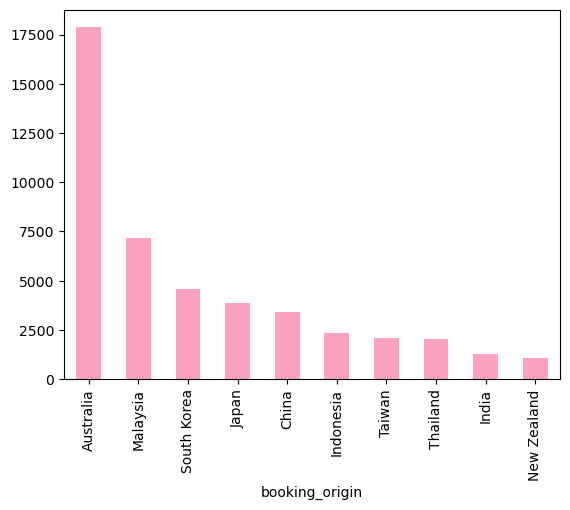

In [17]:
#top10 booking countries
df['booking_origin'].value_counts().head(10).plot(kind = 'bar')

This graph shows that the highest number of booking tickets were from Australia, and Malaysia was a close second. About 34% of audience hails from the southern region.

<Axes: xlabel='route'>

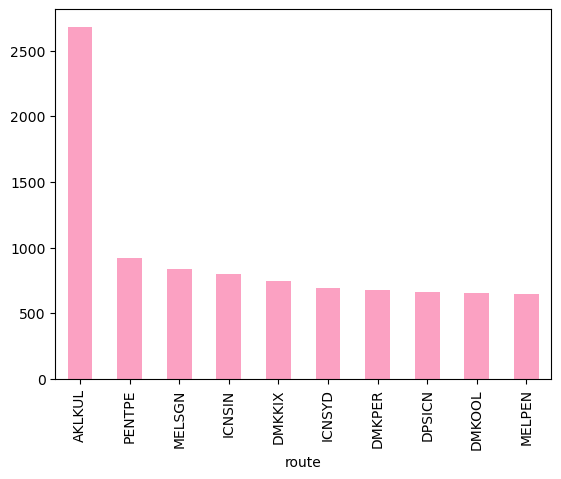

In [19]:
#top10 most preferred routes
df['route'].value_counts().head(10).plot(kind='bar')

As per the data, the most prevalant route is the AKLKUL(Auckland to Kuala Lumpur). Others include PENTPE(Penang to Malaysia), MELSGN(Melbourne to Singapore), etc.

<Axes: xlabel='booking_complete', ylabel='count'>

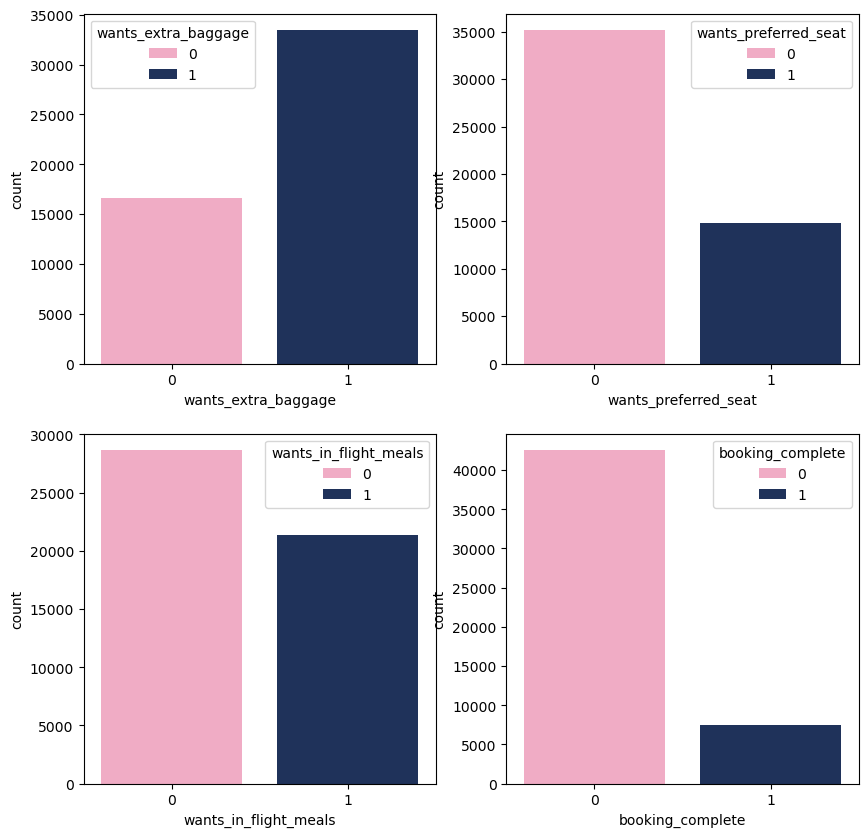

In [21]:
#countplots
fig, ax=plt.subplots(2,2, figsize=(10,10))
sns.countplot(x='wants_extra_baggage',data=df, ax=ax[0,0],hue='wants_extra_baggage')
sns.countplot(x='wants_preferred_seat',data=df, ax=ax[0,1],hue='wants_preferred_seat')
sns.countplot(x='wants_in_flight_meals',data=df, ax=ax[1,0],hue='wants_in_flight_meals')
sns.countplot(x='booking_complete',data=df, ax=ax[1,1],hue='booking_complete')

<Axes: xlabel='flight_hour', ylabel='Count'>

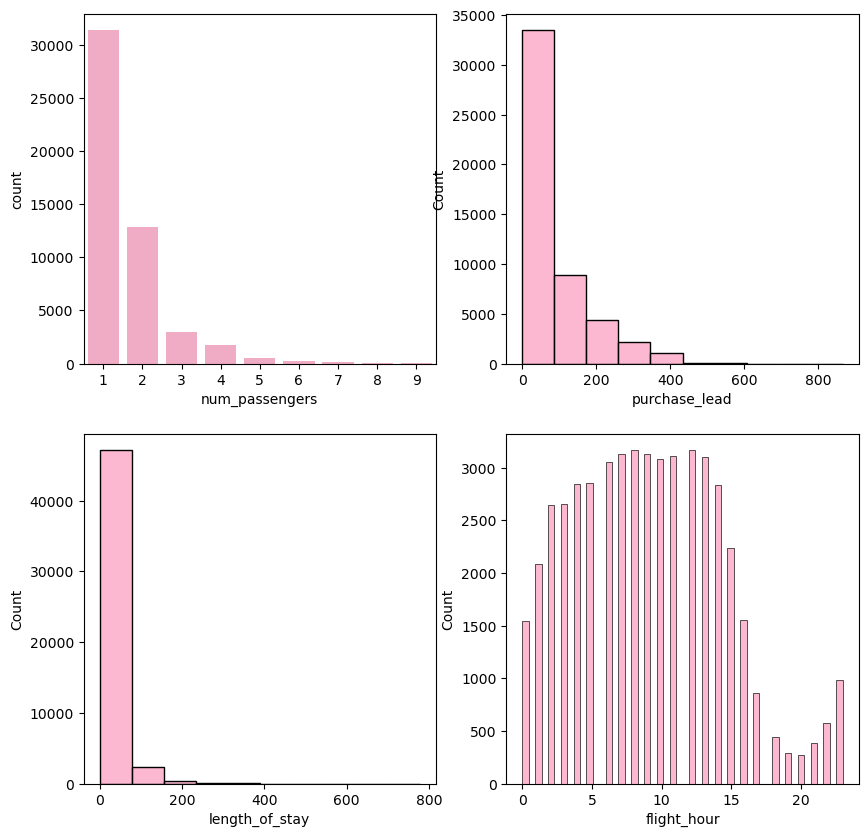

In [22]:
fig, ax=plt.subplots(2,2, figsize=(10,10))
sns.countplot(x='num_passengers',data=df, ax=ax[0,0])
sns.histplot(x='purchase_lead',data=df, ax=ax[0,1],bins=10)
sns.histplot(x='length_of_stay',data=df, ax=ax[1,0],bins=10)
sns.histplot(x='flight_hour',data=df, ax=ax[1,1],bins=50)


<Axes: xlabel='wants_in_flight_meals', ylabel='count'>

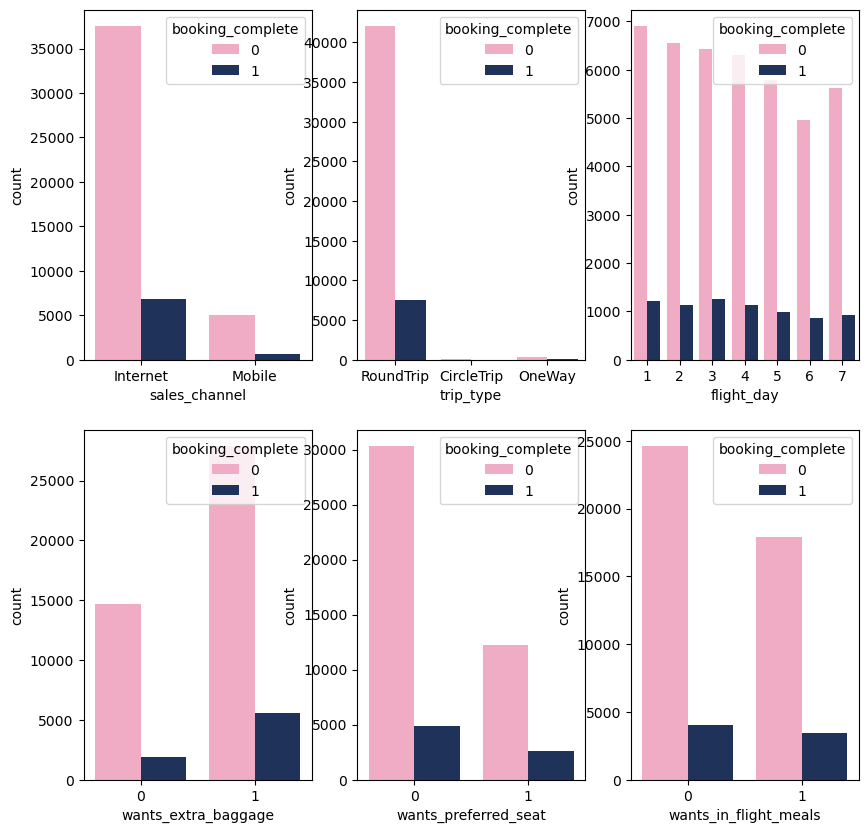

In [23]:
#bivariate analysis
fig, ax=plt.subplots(2,3, figsize=(10,10))
sns.countplot(x='sales_channel',data=df, ax=ax[0,0],hue='booking_complete')
sns.countplot(x='trip_type',data=df, ax=ax[0,1],hue='booking_complete')
sns.countplot(x='flight_day',data=df, ax=ax[0,2],hue='booking_complete')
sns.countplot(x='wants_extra_baggage',data=df, ax=ax[1,0],hue='booking_complete')
sns.countplot(x='wants_preferred_seat',data=df, ax=ax[1,1],hue='booking_complete')
sns.countplot(x='wants_in_flight_meals',data=df, ax=ax[1,2],hue='booking_complete')

### Hypothesis Testing

In [25]:
#taking 3 variables to check dependency: 
# booking origin
# purchase lead- anova
# baggage -chi squared

In [26]:
#chi squared test for extra baggage
from scipy.stats import chi2_contingency

#sample data
samp=df.head(100)
data_c=pd.crosstab(df['wants_extra_baggage'],df['booking_complete'], margins=False)
data_s=pd.crosstab(samp['booking_complete'],samp['wants_extra_baggage'], margins=False)
data_c

booking_complete,0,1
wants_extra_baggage,,
0,14656,1905
1,27866,5573


In [27]:
stat,p, dof, expected= chi2_contingency(data_c)
print('stat=%.3f,p=%.3f' % (stat,p))

stat=231.737,p=0.000


hence, the variable booking complete is not independent, rather dependent on extra baggage, thereby rejecting the null hypothesis.

In [29]:
#anova test
import statsmodels.api as sm
from statsmodels.formula.api import ols

<Axes: xlabel='booking_complete', ylabel='purchase_lead'>

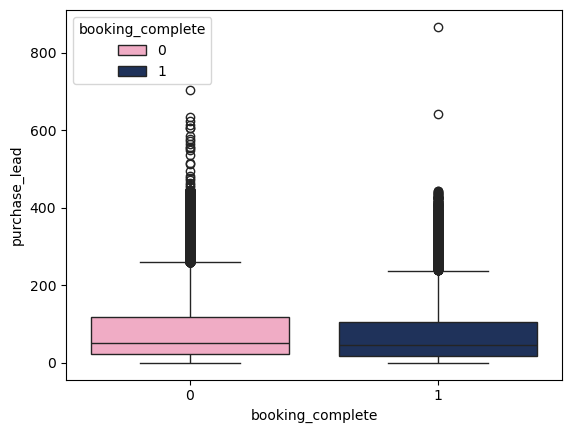

In [30]:
sns.boxplot(x='booking_complete',y='purchase_lead',hue='booking_complete',data=df)

In [31]:
model=ols('purchase_lead ~ booking_complete', data=df).fit()
ann=sm.stats.anova_lm(model, typ=2)
ann
if(p>0.05):
    print('independent variable')
else:
    print('dependent variable')

dependent variable


So, per this results, purchase lead does have an effect on the booking completion. Could be due to better offers elsewhere, change in dates, emergencies, 

### Outlier Removal

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  int64  
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 5.3+ 

In [35]:
#using z-score
from scipy import stats

cols=['num_passengers','purchase_lead','length_of_stay','flight_hour', 'flight_day','flight_duration']

z=np.abs(stats.zscore(df[cols]))

threshold=3

outliers=df[z>threshold]

outliers

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
#handling outliers
df = df[(z < 3).all(axis=1)]

### LabelEncoding

In [38]:
categ=df.select_dtypes(include=['object','category','int64']).columns
categ
categ=df.drop(columns=['num_passengers','purchase_lead','length_of_stay','flight_hour'])

In [39]:
le=LabelEncoder()
for i in categ:
    df[i]=le.fit_transform(df[i])
df

C:\Users\saniy\AppData\Local\Temp\ipykernel_40516\1723314324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]=le.fit_transform(df[i])
C:\Users\saniy\AppData\Local\Temp\ipykernel_40516\1723314324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]=le.fit_transform(df[i])
C:\Users\saniy\AppData\Local\Temp\ipykernel_40516\1723314324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,0,2,262,19,7,5,0,61,1,0,0,8,0
1,1,0,2,112,20,3,5,0,61,0,0,0,8,0
2,2,0,2,243,22,17,2,0,36,1,1,0,8,0
3,1,0,2,96,31,4,5,0,61,0,0,1,8,0
4,2,0,2,68,22,15,2,0,36,1,0,1,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,0,2,27,6,9,5,718,4,1,0,1,9,0
49996,1,0,2,111,6,4,6,718,4,0,0,0,9,0
49997,1,0,2,24,6,22,5,718,4,0,0,1,9,0
49998,1,0,2,15,6,11,0,718,4,1,0,1,9,0


## Model Training

<Axes: >

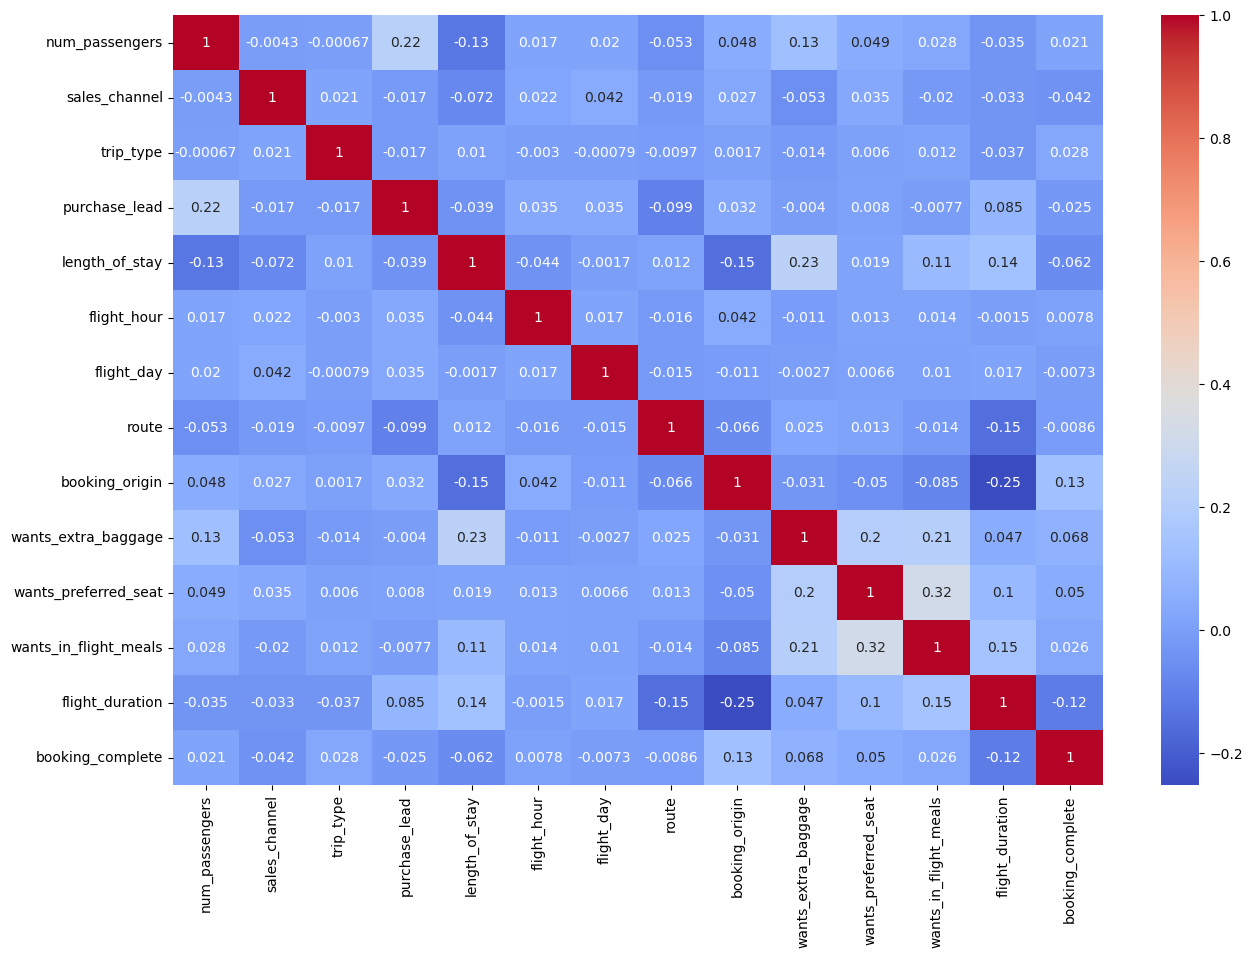

In [121]:
saniya_pal2=mlc.LinearSegmentedColormap.from_list("custom",["#152f64", "#fba1c2"])
cor=df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(cor, annot=True,cmap='coolwarm')

In [122]:
#training and testing
x=df.drop(columns=['booking_complete'])
y=df['booking_complete']

In [123]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.4,random_state=42)

In [124]:
rfc=RandomForestClassifier(random_state=0, max_features='sqrt', n_estimators=200, class_weight='balanced')
dtc=DecisionTreeClassifier(random_state=0, max_depth= 12, min_samples_leaf=2, min_samples_split=2, class_weight='balanced')

In [125]:
rfc.fit(x_train,y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=0)

In [126]:
rfc.score(x_train,y_train)

0.9999292836433067

In [127]:
rfc_pred=rfc.predict(x_test)
rfc_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [128]:
dtc.fit(x_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=12,
                       min_samples_leaf=2, random_state=0)

In [129]:
dtc.score(x_train,y_train)

0.753093840605332

In [130]:
dtc_pred=dtc.predict(x_test)
dtc_pred

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

## Model Evalation

Text(0.5, 1.0, 'Decision Tree')

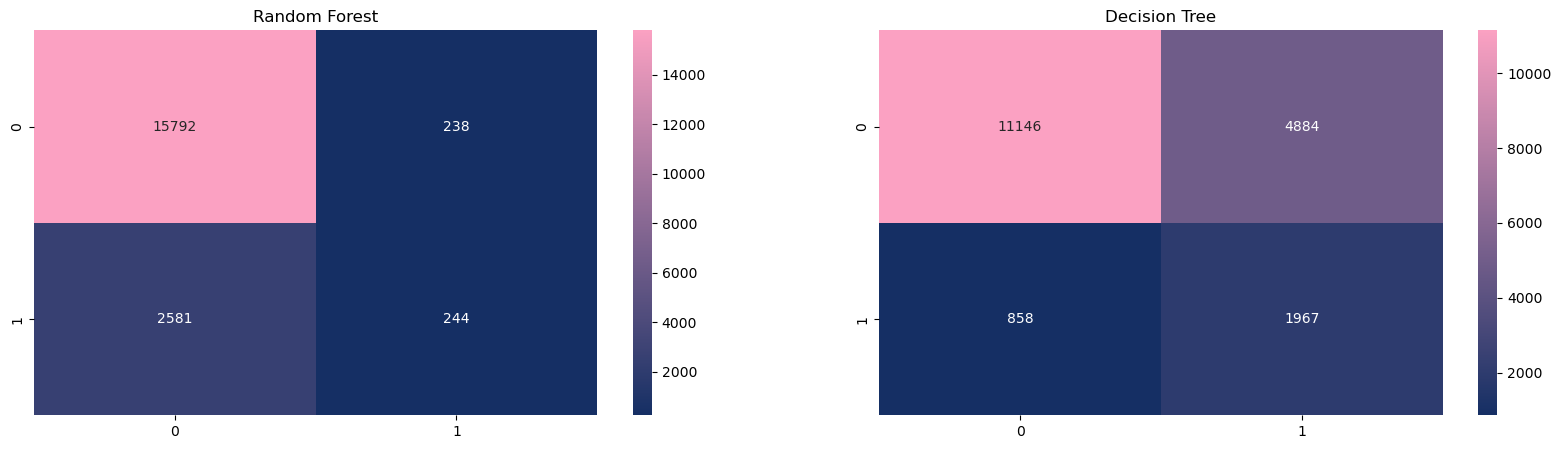

In [132]:
from sklearn.metrics import confusion_matrix
import matplotlib.colors as mlc
fig,ax=plt.subplots(1,2,figsize=(20,5))
saniya_pal2=mlc.LinearSegmentedColormap.from_list("custom",["#152f64", "#fba1c2"])
sns.heatmap(confusion_matrix(y_test,rfc_pred),annot=True,fmt='d', ax=ax[0],cmap=saniya_pal2).set_title('Random Forest') #fmt to get integer results
sns.heatmap(confusion_matrix(y_test,dtc_pred),annot=True,fmt='d', ax=ax[1],cmap=saniya_pal2).set_title('Decision Tree')

In [133]:
from math import sqrt
print('Random Forest Scores')
print('Accuracy Score: ', accuracy_score(y_test, rfc_pred))
print('Precision Score: ', precision_score(y_test, rfc_pred))
print('Recall Score: ', recall_score(y_test, rfc_pred))
print('F1 Score: ', f1_score(y_test, rfc_pred))
print('RMSE: ',sqrt(mean_squared_error(y_test,rfc_pred)))

Random Forest Scores
Accuracy Score:  0.8504905860514452
Precision Score:  0.5062240663900415
Recall Score:  0.0863716814159292
F1 Score:  0.14756576957967946
RMSE:  0.38666447205368476


In [134]:
print('Decision Tree Scores')
print('Accuracy Score: ', accuracy_score(y_test, dtc_pred))
print('Precision Score: ', precision_score(y_test, dtc_pred))
print('Recall Score: ', recall_score(y_test, dtc_pred))
print('F1 Score: ', f1_score(y_test, dtc_pred))
print('RMSE: ',sqrt(mean_squared_error(y_test,dtc_pred)))

Decision Tree Scores
Accuracy Score:  0.6954653937947494
Precision Score:  0.2871113706028317
Recall Score:  0.6962831858407079
F1 Score:  0.4065729640347251
RMSE:  0.551846542260845


Therefore, RandomForest is the best model for this data.

In [136]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [140]:
import lightgbm as lgb

In [141]:
skf=StratifiedKFold(n_splits=10, shuffle=True, random_state=529)

In [142]:
cvscore=cross_val_score(rfc, x, y.values, cv=skf,scoring='accuracy')
print(cvscore)
np.average(cvscore)

[0.85256682 0.85065762 0.85214255 0.85829444 0.85341536 0.85532457
 0.84959695 0.85465733 0.85211118 0.85826438]


0.8537031190684716

In [143]:
model=lgb.LGBMClassifier(n_estimators=100)
model.fit(x_train,y_train)

[LightGBM] [Info] Number of positive: 4216, number of negative: 24066
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 28282, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149070 -> initscore=-1.741913
[LightGBM] [Info] Start training from score -1.741913


LGBMClassifier()

In [146]:
lgb_pred=model.predict(x_test)

In [147]:
from math import sqrt
print('LightboostGBM Scores')
print('Accuracy Score: ', accuracy_score(y_test, lgb_pred))
print('Precision Score: ', precision_score(y_test, lgb_pred))
print('Recall Score: ', recall_score(y_test, lgb_pred))
print('F1 Score: ', f1_score(y_test, lgb_pred))
print('RMSE: ',sqrt(mean_squared_error(y_test,lgb_pred)))

LightboostGBM Scores
Accuracy Score:  0.8512861309997348
Precision Score:  0.5261845386533666
Recall Score:  0.07469026548672567
F1 Score:  0.13081215127092374
RMSE:  0.3856343721717051


In [148]:
cvscore=cross_val_score(model, x, y.values, cv=skf,scoring='accuracy')
print(cvscore)
np.average(cvscore)

[LightGBM] [Info] Number of positive: 6337, number of negative: 36086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 42423, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149377 -> initscore=-1.739500
[LightGBM] [Info] Start training from score -1.739500
[LightGBM] [Info] Number of positive: 6337, number of negative: 36086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 42423, number of used features: 13
[LightGBM] [Info] [bin

0.8510723595474868

### Hyperparameter tuning

In [150]:
from sklearn.model_selection import GridSearchCV

#parameters for grid search
param_grid = {
    "num_leaves": [31, 63, 127],
    "max_depth": [-1, 3, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}
# Grid Search Object
grid = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)

#fitting the grid search
grid.fit(x_train, y_train)

#best parameters
print(grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[LightGBM] [Info] Number of positive: 4216, number of negative: 24066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 28282, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149070 -> initscore=-1.741913
[LightGBM] [Info] Start training from score -1.741913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [151]:
#applying the best parameters to our model
model=lgb.LGBMClassifier(colsample_bytree= 1.0, max_depth=5, num_leaves= 63, subsample= 0.8, n_estimators=100)

In [152]:
model.fit(x_train,y_train)

[LightGBM] [Info] Number of positive: 4216, number of negative: 24066
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 28282, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149070 -> initscore=-1.741913
[LightGBM] [Info] Start training from score -1.741913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

LGBMClassifier(max_depth=5, num_leaves=63, subsample=0.8)

In [153]:
lgb_pred=model.predict(x_test)

In [154]:
print('LightboostGBM Scores')
print('Accuracy Score: ', accuracy_score(y_test, lgb_pred))
print('Precision Score: ', precision_score(y_test, lgb_pred))
print('Recall Score: ', recall_score(y_test, lgb_pred))
print('F1 Score: ', f1_score(y_test, lgb_pred))
print('RMSE: ',sqrt(mean_squared_error(y_test,lgb_pred)))

LightboostGBM Scores
Accuracy Score:  0.8502254044020153
Precision Score:  0.5014245014245015
Recall Score:  0.062300884955752214
F1 Score:  0.11083123425692695
RMSE:  0.38700722938723586


In [155]:
cvscore=cross_val_score(model, x, y.values, cv=skf,scoring='accuracy')
print(cvscore)
np.average(cvscore)

[LightGBM] [Info] Number of positive: 6337, number of negative: 36086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 42423, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149377 -> initscore=-1.739500
[LightGBM] [Info] Start training from score -1.739500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

0.8506267969844105

therefore, we achieved an accuracy of 85% in our model with hyperparameter tuning and using an LGBM model.

Text(0.5, 1.0, 'LightBoostGBM')

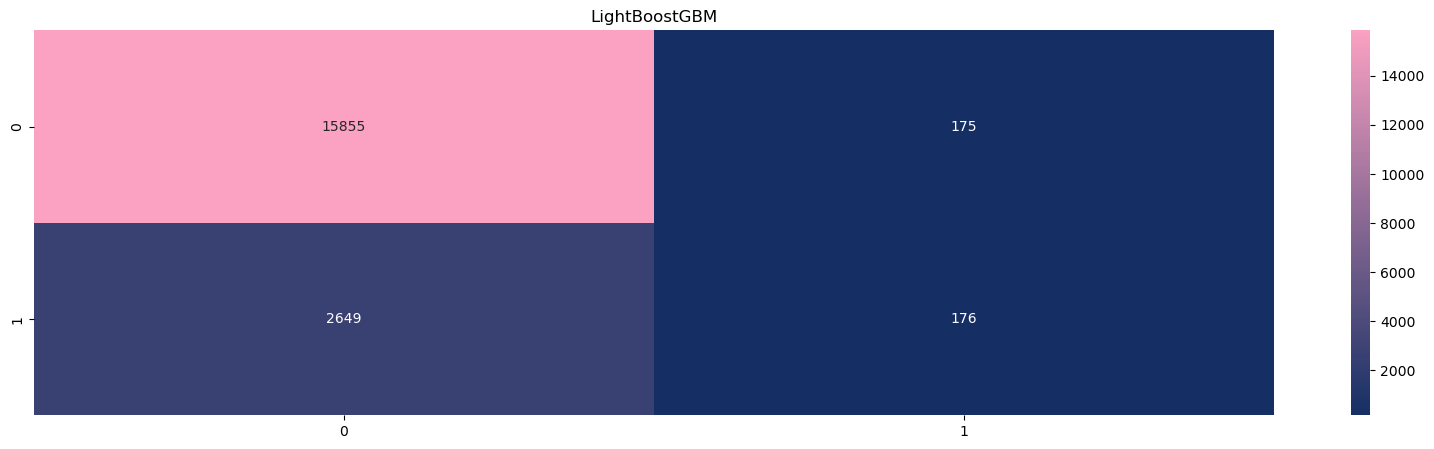

In [157]:
fig,ax=plt.subplots(1,1,figsize=(20,5))
saniya_pal2=mlc.LinearSegmentedColormap.from_list("custom",["#152f64", "#fba1c2"])
sns.heatmap(confusion_matrix(y_test,lgb_pred),annot=True,fmt='d',cmap=saniya_pal2).set_title('LightBoostGBM') #fmt to get integer results

### Features Importances

In [159]:
feat_df=pd.DataFrame({'Features':x_train.columns, 'Importances':model.feature_importances_})
feat_df = feat_df.sort_values(by='Importances', ascending=False)
feat_df

,Features,Importances
7,route,594
8,booking_origin,419
4,length_of_stay,362
3,purchase_lead,355
5,flight_hour,222
12,flight_duration,193
6,flight_day,117
1,sales_channel,61
9,wants_extra_baggage,53
10,wants_preferred_seat,48


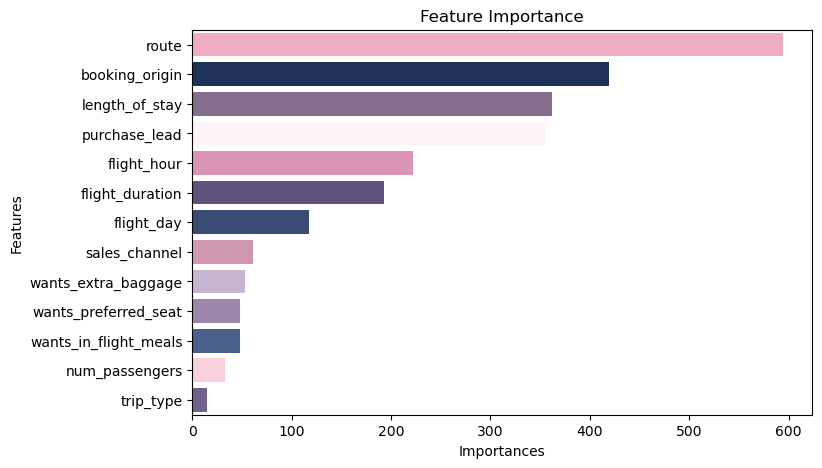

In [160]:
plt.figure(figsize=(8,5))
sns.barplot(x='Importances', y='Features', data=feat_df,hue='Features')
plt.title('Feature Importance')
plt.show()